In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 

pd.options.display.max_columns = 500

file_path = 'cybersecurity_attacks.csv'
df = pd.read_csv(file_path)

In [64]:
raw_df = df.copy()
raw_df = raw_df.drop(columns=["Source IP Address", "Destination IP Address", "Payload Data", "User Information"])

# Transforming columns in the data

All the EDA process has been done by the DA & DE team, in this file we just directly implement our data pre-processing and transformation

In [65]:
print(f"Malware Indicators: {raw_df['Malware Indicators'].value_counts()}")
print(f"Alerts/Warnings: {raw_df['Alerts/Warnings'].value_counts()}")
print(f"Proxy Information: {raw_df['Proxy Information'].value_counts()}")
print(f"Firewall Logs: {raw_df['Firewall Logs'].value_counts()}")
print(f"IDS/IPS Alerts: {raw_df['IDS/IPS Alerts'].value_counts()}")

Malware Indicators: Malware Indicators
IoC Detected    20000
Name: count, dtype: int64
Alerts/Warnings: Alerts/Warnings
Alert Triggered    19933
Name: count, dtype: int64
Proxy Information: Proxy Information
39.123.165.122     2
150.9.97.135       1
198.80.71.196      1
108.143.243.168    1
211.195.173.251    1
                  ..
205.112.169.158    1
78.192.52.63       1
157.191.153.187    1
205.183.87.116     1
112.169.115.139    1
Name: count, Length: 20148, dtype: int64
Firewall Logs: Firewall Logs
Log Data    20039
Name: count, dtype: int64
IDS/IPS Alerts: IDS/IPS Alerts
Alert Data    19950
Name: count, dtype: int64


# Columns to drop - might have to drop

- ids/ips alers
- firewall logs

In [66]:
# Convert to Timestamp column into Date and Time columns
raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'])

# Create separate columns
raw_df['hour'] = raw_df['Timestamp'].dt.hour
raw_df['day'] = raw_df['Timestamp'].dt.day
raw_df['year'] = raw_df['Timestamp'].dt.year
raw_df['week_day'] = raw_df['Timestamp'].dt.weekday
raw_df['month'] = raw_df['Timestamp'].dt.month
raw_df[['Timestamp', 'hour', 'day', 'week_day','month','year']].head()

raw_df = raw_df.drop(columns=['Timestamp', 'year'])

In [67]:
catergorical_cols = ['Source Port', 'Destination Port']
raw_df[catergorical_cols] = raw_df[catergorical_cols].astype('object')

In [68]:
# Split Geo-location Data column into City and State
raw_df[['City', 'State']] = df['Geo-location Data'].str.split(',', n=1, expand=True)
raw_df['City'] = raw_df['City'].str.strip()
raw_df['State'] = raw_df['State'].str.strip()

raw_df = raw_df.drop(columns='Geo-location Data')

In [69]:
raw_df = raw_df.drop(columns=['City', 'State'])

In [70]:
# Apply Binary encoding
raw_df['Malware Indicators'] = raw_df['Malware Indicators'].notna().astype(int)
raw_df['Alerts/Warnings'] = raw_df['Alerts/Warnings'].notna().astype(int)
raw_df['Firewall Logs'] = raw_df['Firewall Logs'].notna().astype(int)
raw_df['IDS/IPS Alerts'] = raw_df['IDS/IPS Alerts'].notna().astype(int)

In [71]:
# Create a binary indicator for proxy presence
raw_df['Has_Proxy'] = raw_df['Proxy Information'].notna().astype(int)

# Check distribution of attacks with/without proxy
print("Attack distribution by Proxy presence:")
crosstab = pd.crosstab(raw_df['Has_Proxy'], raw_df['Attack Type'], normalize='index') * 100
print(crosstab)

Attack distribution by Proxy presence:
Attack Type       DDoS  Intrusion    Malware
Has_Proxy                                   
0            33.464309  33.590247  32.945444
1            33.674128  32.741079  33.584793


In [72]:
raw_df = raw_df.drop(columns=['Has_Proxy', 'Proxy Information', 'IDS/IPS Alerts', 'Firewall Logs'])

# Creating new columns from the dataset

In [73]:
raw_df['Browser'] = raw_df['Device Information'].str.split('/').str[0]
raw_df['Browser']

0        Mozilla
1        Mozilla
2        Mozilla
3        Mozilla
4        Mozilla
          ...   
39995    Mozilla
39996    Mozilla
39997    Mozilla
39998    Mozilla
39999    Mozilla
Name: Browser, Length: 40000, dtype: object

In [74]:
import re
# OS and device patterns to search for
patterns = [
    r'Windows',
    r'Linux',
    r'Android',
    r'iPad',
    r'iPod',
    r'iPhone',
    r'Macintosh',
]

def extract_device_or_os(user_agent):
    for pattern in patterns:
        match = re.search(pattern, user_agent, re.I)  # re.I makes the search case-insensitive
        if match:
            return match.group()
    return 'Unknown'  # Return 'Unknown' if no patterns match

# Extract device or OS
raw_df['Device/OS'] = raw_df['Device Information'].apply(extract_device_or_os)

In [25]:
import pandas as pd
from user_agents import parse

def parse_ua(ua_string):
    ua = parse(ua_string)
    return pd.Series({
        "browser_version": ua.browser.version_string,
        "os_version": ua.os.version_string,
        "device_type": (
            "Mobile" if ua.is_mobile else
            "Tablet" if ua.is_tablet else
            "PC" if ua.is_pc else
            "Bot" if ua.is_bot else
            "Other"
        )
    })

# Apply to dataframe
features_df = raw_df["Device Information"].apply(parse_ua)

raw_df = pd.concat([raw_df, features_df], axis=1)

In [26]:
raw_df = raw_df.drop('Device Information', axis = 1)

In [27]:
raw_df['browser_version'] = (raw_df['browser_version']
    .astype(str)
    .str.split('.', n=1)
    .str[0]
    .astype('Int64')  # nullable int
)

In [28]:
raw_df['os_version'] = (
    raw_df['os_version']
    .replace('', 'Unknown')                
    .astype(str)
    .str.split('.', n=1)
    .str[0]
)

In [ ]:
modern_os = ['10', '11', '8', 'Vista', '7']
old_os = ['XP', '2000', 'ME']
ancient_os = ['98', '95', 'NT', 'CE']

raw_df['os_age_category'] = 'Unknown'
raw_df.loc[raw_df['os_version'].isin(modern_os), 'os_age_category'] = 'Modern'
raw_df.loc[raw_df['os_version'].isin(old_os), 'os_age_category'] = 'Old'
raw_df.loc[raw_df['os_version'].isin(ancient_os), 'os_age_category'] = 'Ancient'

dict_map = {'Modern': 3, 'Old': 2, 'Ancient':1 , 'Unknown': 0}
raw_df['os_age_category'] = raw_df['os_age_category'].map(dict_map)

In [75]:
# Separate by number of unique values
binary_cols = []      
low_cardinality = []  

target_col = 'attack_type'

# Find all object-type columns excluding the target column
object_cols = [col for col in raw_df.columns.tolist()
                if col != target_col]

for col in object_cols:
    n_unique = raw_df[col].nunique()
    if n_unique == 2:
        binary_cols.append(col)
    elif n_unique <= 15:
        low_cardinality.append(col)

print(f"\nBinary (2 values): {binary_cols}")
print(f"Low cardinality (3-10): {low_cardinality}")


Binary (2 values): ['Packet Type', 'Malware Indicators', 'Alerts/Warnings', 'Attack Signature', 'Log Source', 'Browser']
Low cardinality (3-10): ['Protocol', 'Traffic Type', 'Attack Type', 'Action Taken', 'Severity Level', 'Network Segment', 'week_day', 'month', 'Device/OS']


In [76]:
# Define new column names
column_mapping = {
    'Source Port': 'source_port',
    'Destination Port': 'destination_port',
    'Protocol': 'protocol',
    'Packet Length': 'packet_length',
    'Packet Type': 'packet_type',
    'Traffic Type': 'traffic_type',
    'Malware Indicators': 'malware_indicators',
    'Anomaly Scores': 'anomaly_scores',
    'Alerts/Warnings': 'alerts_warnings',
    'Attack Type': 'attack_type',
    'Attack Signature': 'attack_signature',
    'Action Taken': 'action_taken',
    'Severity Level': 'severity_level',
    'Network Segment': 'network_segment',
    # 'Firewall Logs': 'firewall_logs',
    # 'IDS/IPS Alerts': 'ids_ips_alerts',
    'Log Source': 'log_source',
    'hour': 'hour',
    'day': 'day',
    'week_day': 'week_day',
    'month': 'month',
    'Browser': 'browser',
    'Device/OS': 'device_os',
    # 'browser_version': 'browser_version',
    # 'os_version': 'os_version',
    # 'device_type': 'device_type',
    # 'os_age_category': 'os_age_category'
    # 'x_noised': 'packet_length_noised'  
}

# Rename columns
raw_df.rename(columns=column_mapping, inplace=True)

Columns with 2 unique values => Binary encode

Packet Types
- Data: 0
- Control: 1

Log Source
- Server: 0
- Firewall: 1

In [78]:
raw_df = raw_df.drop('Device Information', axis=1)

In [132]:
raw_df['packet_type'] = raw_df['packet_type'].notna().astype(int)
raw_df['log_source'] = raw_df['log_source'].notna().astype(int)

In [133]:
# plan is to take seperate dataframes for attack type
malware = raw_df.where(raw_df['attack_type']=='Malware')
malware = malware.drop_duplicates()
malware.shape

(13308, 21)

In [134]:
ddos = raw_df.where(raw_df['attack_type']=='DDoS')
ddos = ddos.drop_duplicates()
ddos.shape

(13429, 21)

In [135]:
intrusion = raw_df.where(raw_df['attack_type']=='Intrusion')
intrusion = intrusion.drop_duplicates()
intrusion.shape

(13266, 21)

In [136]:
malware_sm = malware.sample(2000)
ddos_sm = ddos.sample(2000)
intrusion_sm  = intrusion.sample(2000)

In [125]:
combined_df =  pd.concat([malware_sm, ddos_sm, intrusion_sm], ignore_index=True)

# An Idea to tackle the problem of synthetic data

- we have now 2000 cases of each attack type
- we use smote to generate samples, which create minority relations in the dataset

<br>

- for each attack type we generate random sample
- we then combine everything, where are the minor relations between classes, can be distingushed by clustering etc.
- we use our sample cases from the first as our test

## Generating samples using smote

In [ ]:
malware_sm = malware_sm.drop(['source_port', 'destination_port'], axis=1)
malware_sm.head()

protocol  packet_length  packet_type traffic_type  malware_indicators  \
1236       UDP            502            1          FTP                   1   
35744      UDP            295            1          FTP                   0   
25536     ICMP           1179            1         HTTP                   1   
12588      TCP            820            1          FTP                   1   
17937      UDP            997            1         HTTP                   1   

       anomaly_scores  alerts_warnings attack_type attack_signature  \
1236               14                0     Malware  Known Pattern A   
35744              38                0     Malware  Known Pattern B   
25536              74                1     Malware  Known Pattern B   
12588              57                0     Malware  Known Pattern B   
17937               4                1     Malware  Known Pattern B   

      action_taken network_segment  log_source  hour  day  week_day  month  \
1236        Logged       Segment A           1    17   18         6      4   
35744       Logged       Segment B           1    19   28         6      2   
25536      Ignored       Segment A           1     8   13         3      8   
12588       Logged       Segment B           1    21   16         0      8   
17937      Blocked       Segment A           1    22   20         1      6   

       browser device_os  severity_encoded  
1236   Mozilla   Windows                 0  
35744  Mozilla   Windows                 2  
25536  Mozilla     Linux                 2  
12588  Mozilla   Windows                 1  
17937  Mozilla    iPhone                 1

In [141]:
float_cols = malware_sm.select_dtypes(include=['float']).columns
malware_sm[float_cols] = malware_sm[float_cols].round().astype(int)

In [143]:
from imblearn.over_sampling import SMOTENC

X = malware_sm.drop('attack_type', axis=1)
y = malware_sm['attack_type']

categorical_features = [0, 3,8, 9, 10,16, 17,18]  # index positions of categorical columns

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

X_resampled, y_resampled = smote_nc.fit_resample(X, y)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

## Resolving the problem

- so the problem is we are tyring to sample each one using smote, but it needs more than 1 class in the label
- so what we can do it we need to iterate the process of keeping the attack type of ddos and intrusion more than the malware and vice versa

### Malware

In [158]:
malware_sm = malware.sample(200)
ddos_sm = ddos.sample(1500)
intrusion_sm  = intrusion.sample(1600)

malware_df =  pd.concat([malware_sm, ddos_sm, intrusion_sm], ignore_index=True)

# Ordinal encode Severity Level
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
malware_df['severity_encoded'] = malware_df['severity_level'].map(severity_mapping)
malware_df.drop('severity_level', axis=1, inplace=True)

float_cols = malware_df.select_dtypes(include=['float']).columns
malware_df[float_cols] = malware_df[float_cols].round().astype(int)

malware_df = malware_df.drop(['source_port', 'destination_port'], axis=1)

X = malware_df.drop('attack_type', axis=1)
y = malware_df['attack_type']

cat = X.select_dtypes(include=['object']).columns.to_list() # index positions of categorical columns

smote_nc = SMOTENC(categorical_features=cat, random_state=42)

malware_X_resampled, malware_y_resampled = smote_nc.fit_resample(X, y)

In [161]:
print(f"Shape the generated samples of malware attack type: {malware_X_resampled.shape}")

Shape the generated samples of malware attack type: (4800, 18)


### ddos

In [163]:
malware_sm = malware.sample(1500)
ddos_sm = ddos.sample(200)
intrusion_sm  = intrusion.sample(1600)

ddos_df =  pd.concat([malware_sm, ddos_sm, intrusion_sm], ignore_index=True)

# Ordinal encode Severity Level
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
ddos_df['severity_encoded'] = ddos_df['severity_level'].map(severity_mapping)
ddos_df.drop('severity_level', axis=1, inplace=True)

float_cols = ddos_df.select_dtypes(include=['float']).columns
ddos_df [float_cols] = ddos_df [float_cols].round().astype(int)

ddos_df = ddos_df.drop(['source_port', 'destination_port'], axis=1)

X = ddos_df.drop('attack_type', axis=1)
y = ddos_df['attack_type']

cat = X.select_dtypes(include=['object']).columns.to_list() # index positions of categorical columns

smote_nc = SMOTENC(categorical_features=cat, random_state=42)

ddos_X_resampled, ddos_y_resampled = smote_nc.fit_resample(X, y)

print(f"Shape the generated samples of ddos attack type: {ddos_X_resampled.shape}")

Shape the generated samples of ddos attack type: (4800, 18)


### intrusion

In [164]:
malware_sm = malware.sample(1500)
ddos_sm = ddos.sample(1400)
intrusion_sm  = intrusion.sample(200)

intrusion_df =  pd.concat([malware_sm, ddos_sm, intrusion_sm], ignore_index=True)

# Ordinal encode Severity Level
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
intrusion_df['severity_encoded'] = intrusion_df['severity_level'].map(severity_mapping)
intrusion_df.drop('severity_level', axis=1, inplace=True)

float_cols = intrusion_df.select_dtypes(include=['float']).columns
intrusion_df[float_cols] = intrusion_df[float_cols].round().astype(int)

intrusion_df = intrusion_df.drop(['source_port', 'destination_port'], axis=1)

X = intrusion_df.drop('attack_type', axis=1)
y = intrusion_df['attack_type']

cat = X.select_dtypes(include=['object']).columns.to_list() # index positions of categorical columns

smote_nc = SMOTENC(categorical_features=cat, random_state=42)

intrusion_X_resampled, intrusion_y_resampled = smote_nc.fit_resample(X, y)

print(f"Shape the generated samples of ddos attack type: {intrusion_X_resampled.shape}")

Shape the generated samples of ddos attack type: (4500, 18)


In [165]:
smote_generated_data = pd.concat([malware_X_resampled, ddos_X_resampled, intrusion_X_resampled], ignore_index=True)
print(f"Shape the generated samples using smote are: {smote_generated_data.shape}")

Shape the generated samples using smote are: (14100, 18)


In [166]:
smote_generated_data_target = pd.concat([malware_y_resampled, ddos_y_resampled, intrusion_y_resampled], ignore_index=True)
print(f"Shape the generated target samples using smote are: {smote_generated_data_target.shape}")

Shape the generated target samples using smote are: (14100,)


# Analysis of the smote generated data

In [167]:
smote_generated_data

protocol  packet_length  packet_type traffic_type  malware_indicators  \
0          UDP            332            1          DNS                   1   
1          UDP           1366            1         HTTP                   1   
2          TCP            648            1         HTTP                   1   
3          TCP           1366            1          DNS                   0   
4         ICMP            516            1         HTTP                   0   
...        ...            ...          ...          ...                 ...   
14095     ICMP            788            1         HTTP                   0   
14096     ICMP           1378            1          DNS                   0   
14097      TCP            407            1          DNS                   0   
14098      UDP           1174            1          FTP                   0   
14099      UDP            602            1          FTP                   1   

       anomaly_scores  alerts_warnings attack_signature action_taken  \
0                  29                0  Known Pattern B      Blocked   
1                  88                0  Known Pattern B       Logged   
2                  27                1  Known Pattern A      Blocked   
3                  83                1  Known Pattern A      Blocked   
4                  77                0  Known Pattern A      Ignored   
...               ...              ...              ...          ...   
14095              79                0  Known Pattern A       Logged   
14096              22                1  Known Pattern A      Ignored   
14097              16                0  Known Pattern B      Ignored   
14098              58                0  Known Pattern B      Blocked   
14099              16                0  Known Pattern B       Logged   

      network_segment  log_source  hour  day  week_day  month  browser  \
0           Segment A           1    21    8         1     11  Mozilla   
1           Segment A           1    19   17         5      7  Mozilla   
2           Segment C           1     3   20         1      7  Mozilla   
3           Segment C           1    16   21         1      7  Mozilla   
4           Segment A           1    23   25         6      4  Mozilla   
...               ...         ...   ...  ...       ...    ...      ...   
14095       Segment A           1    12   26         2      5  Mozilla   
14096       Segment A           1     9   17         4     10  Mozilla   
14097       Segment C           1     4   22         3      4    Opera   
14098       Segment C           1    10   13         1      3  Mozilla   
14099       Segment A           1    20   13         1      3  Mozilla   

       device_os  severity_encoded  
0        Windows                 2  
1      Macintosh                 2  
2        Windows                 1  
3           iPad                 0  
4          Linux                 0  
...          ...               ...  
14095    Windows                 1  
14096    Windows                 1  
14097      Linux                 0  
14098    Windows                 1  
14099    Windows                 2  

[14100 rows x 18 columns]

In [172]:
smote_generated_data['target'] = smote_generated_data_target

In [173]:
smote_generated_data

protocol  packet_length  packet_type traffic_type  malware_indicators  \
0          UDP            332            1          DNS                   1   
1          UDP           1366            1         HTTP                   1   
2          TCP            648            1         HTTP                   1   
3          TCP           1366            1          DNS                   0   
4         ICMP            516            1         HTTP                   0   
...        ...            ...          ...          ...                 ...   
14095     ICMP            788            1         HTTP                   0   
14096     ICMP           1378            1          DNS                   0   
14097      TCP            407            1          DNS                   0   
14098      UDP           1174            1          FTP                   0   
14099      UDP            602            1          FTP                   1   

       anomaly_scores  alerts_warnings attack_signature action_taken  \
0                  29                0  Known Pattern B      Blocked   
1                  88                0  Known Pattern B       Logged   
2                  27                1  Known Pattern A      Blocked   
3                  83                1  Known Pattern A      Blocked   
4                  77                0  Known Pattern A      Ignored   
...               ...              ...              ...          ...   
14095              79                0  Known Pattern A       Logged   
14096              22                1  Known Pattern A      Ignored   
14097              16                0  Known Pattern B      Ignored   
14098              58                0  Known Pattern B      Blocked   
14099              16                0  Known Pattern B       Logged   

      network_segment  log_source  hour  day  week_day  month  browser  \
0           Segment A           1    21    8         1     11  Mozilla   
1           Segment A           1    19   17         5      7  Mozilla   
2           Segment C           1     3   20         1      7  Mozilla   
3           Segment C           1    16   21         1      7  Mozilla   
4           Segment A           1    23   25         6      4  Mozilla   
...               ...         ...   ...  ...       ...    ...      ...   
14095       Segment A           1    12   26         2      5  Mozilla   
14096       Segment A           1     9   17         4     10  Mozilla   
14097       Segment C           1     4   22         3      4    Opera   
14098       Segment C           1    10   13         1      3  Mozilla   
14099       Segment A           1    20   13         1      3  Mozilla   

       device_os  severity_encoded     target  
0        Windows                 2    Malware  
1      Macintosh                 2    Malware  
2        Windows                 1    Malware  
3           iPad                 0    Malware  
4          Linux                 0    Malware  
...          ...               ...        ...  
14095    Windows                 1  Intrusion  
14096    Windows                 1  Intrusion  
14097      Linux                 0  Intrusion  
14098    Windows                 1  Intrusion  
14099    Windows                 2  Intrusion  

[14100 rows x 19 columns]

### Checking the generated data for verification

In [183]:
malware_y_resampled.value_counts()

attack_type
Malware      1600
DDoS         1600
Intrusion    1600
Name: count, dtype: int64

In [184]:
malware_X_resampled['target'] = malware_y_resampled 

- Now here if we use the entire generated dataset would not make any sense
- So, we just subset each new data points generated for each attack type 

In [ ]:
smote_malware = malware_X_resampled[malware_X_resampled['target']=='Malware']

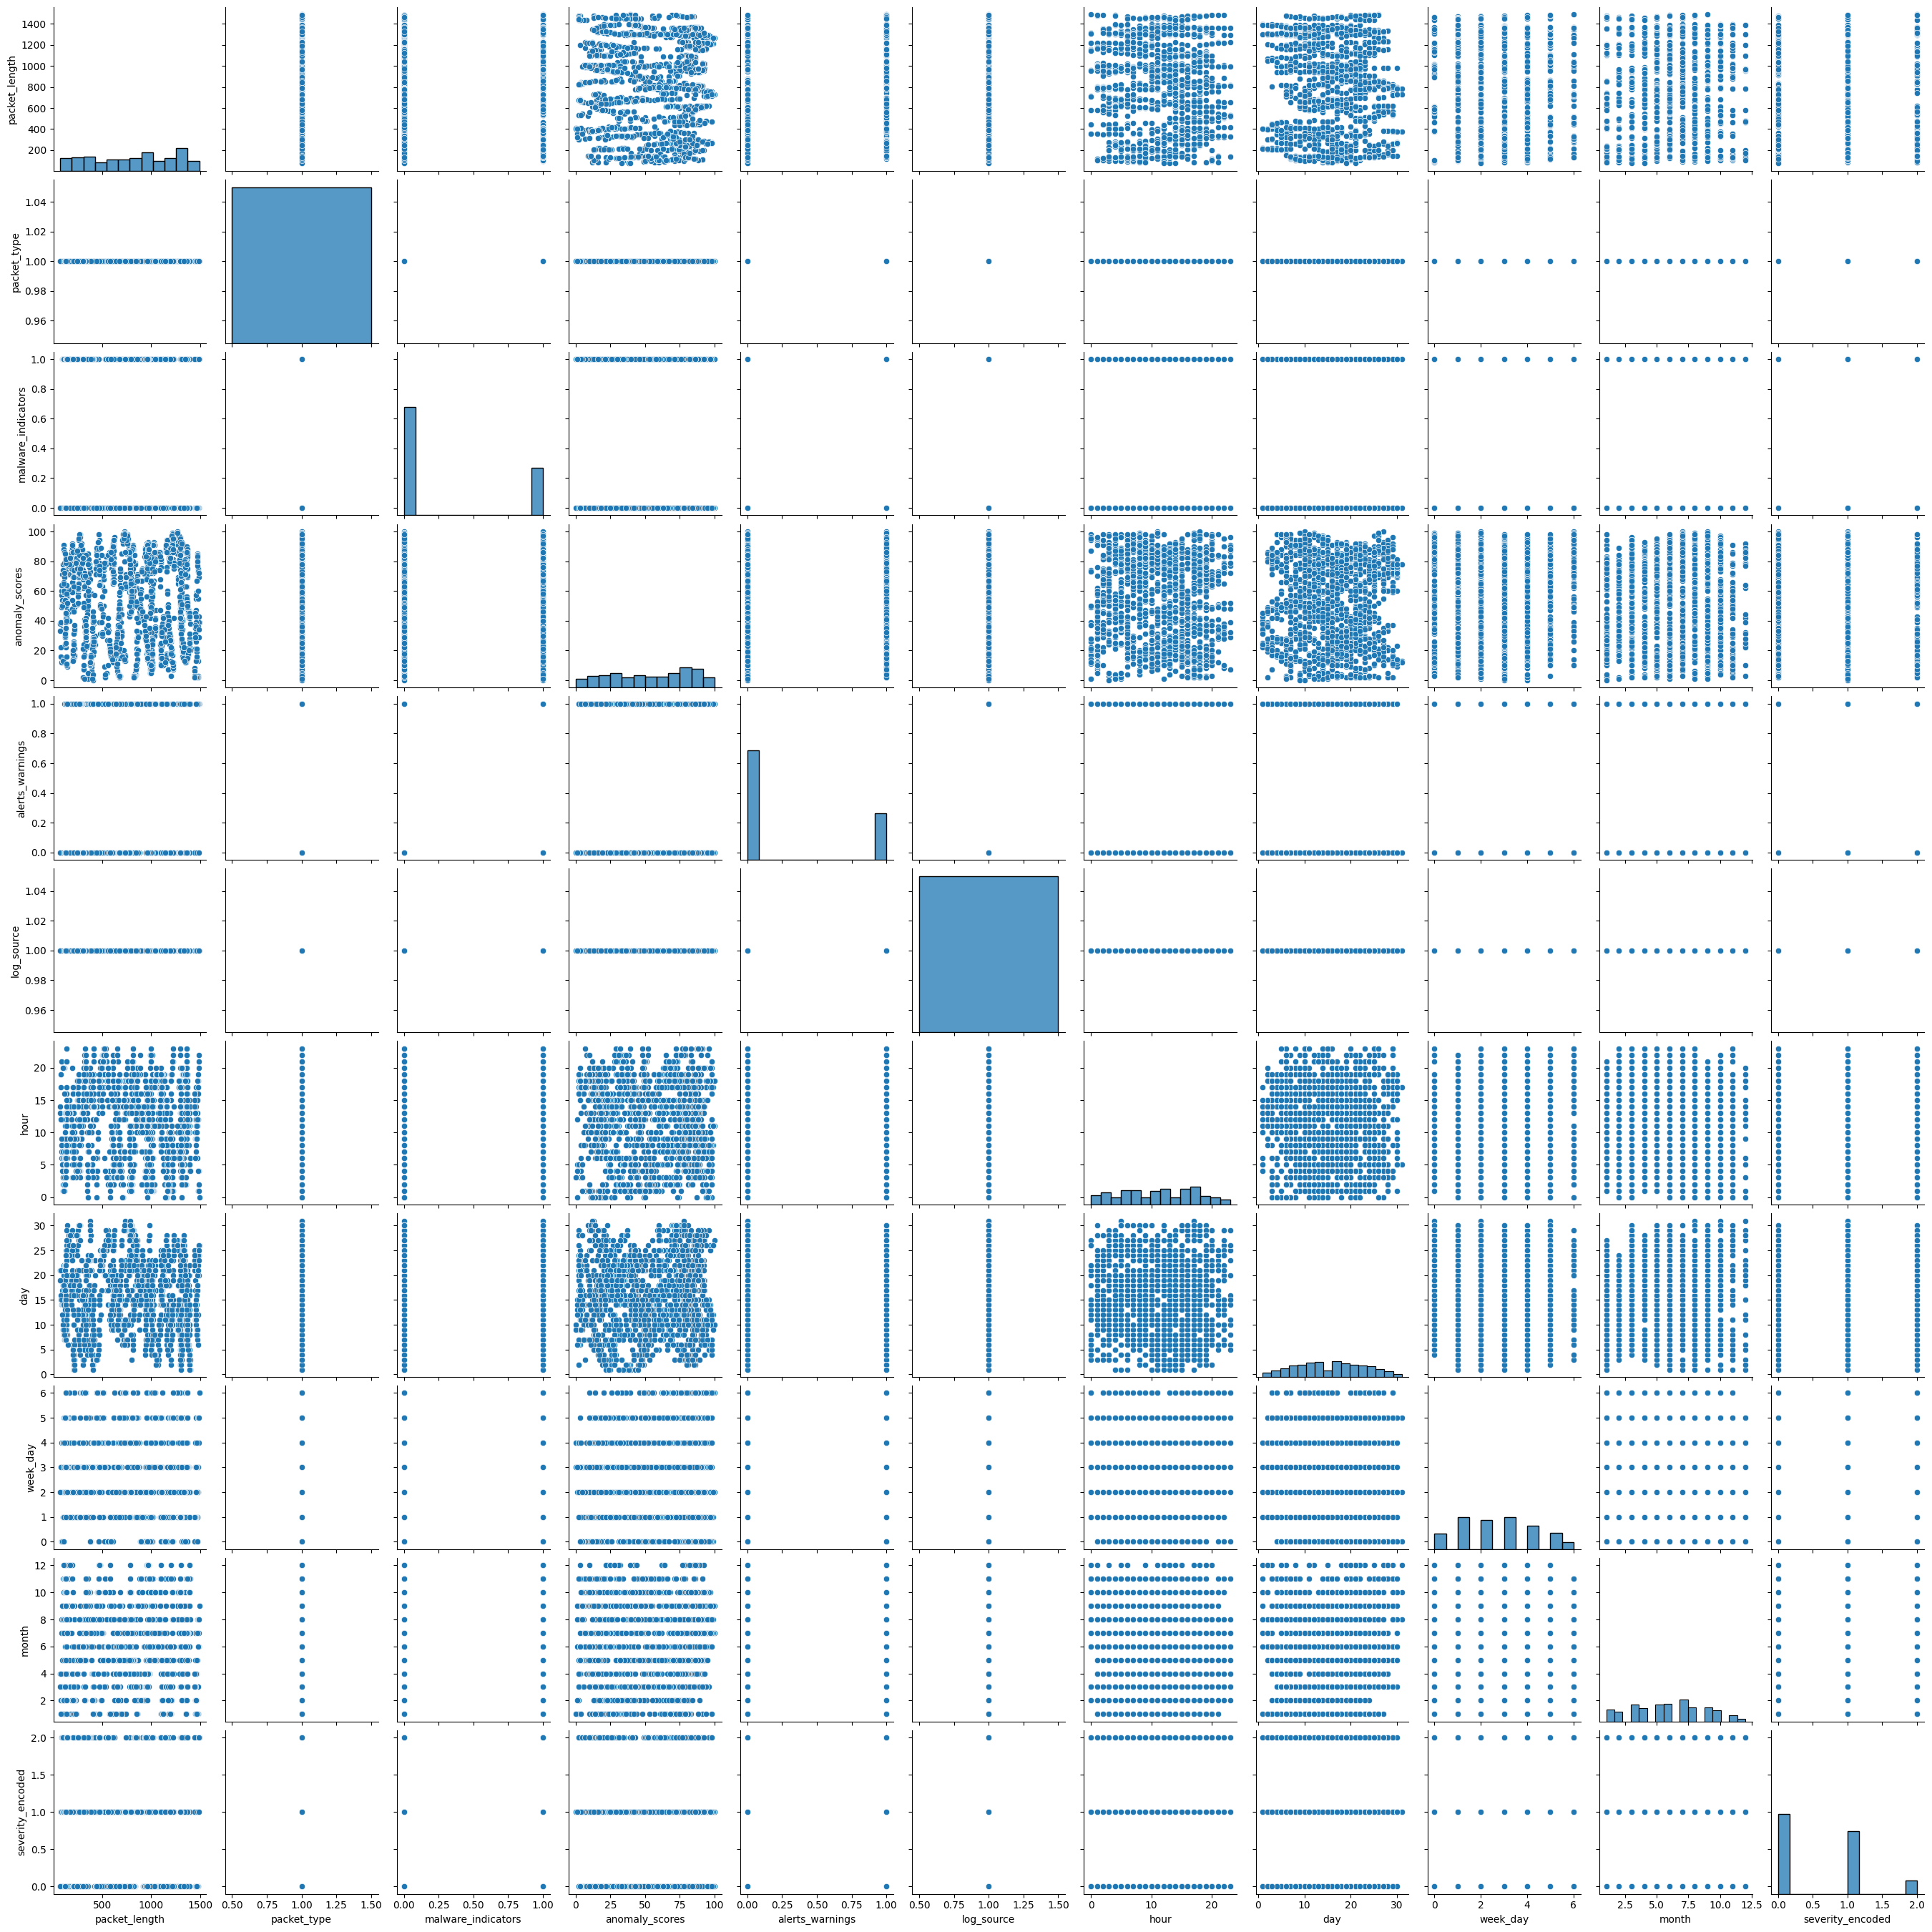

In [190]:
sns.pairplot(smote_malware)

In [192]:
# we do the same of the other 2 targets

ddos_X_resampled['target'] = ddos_y_resampled 
smote_ddos = ddos_X_resampled[ddos_X_resampled['target']=='DDoS']

intrusion_X_resampled['target'] = ddos_y_resampled 
smote_intrusion = intrusion_X_resampled[intrusion_X_resampled['target']=='Intrusion']

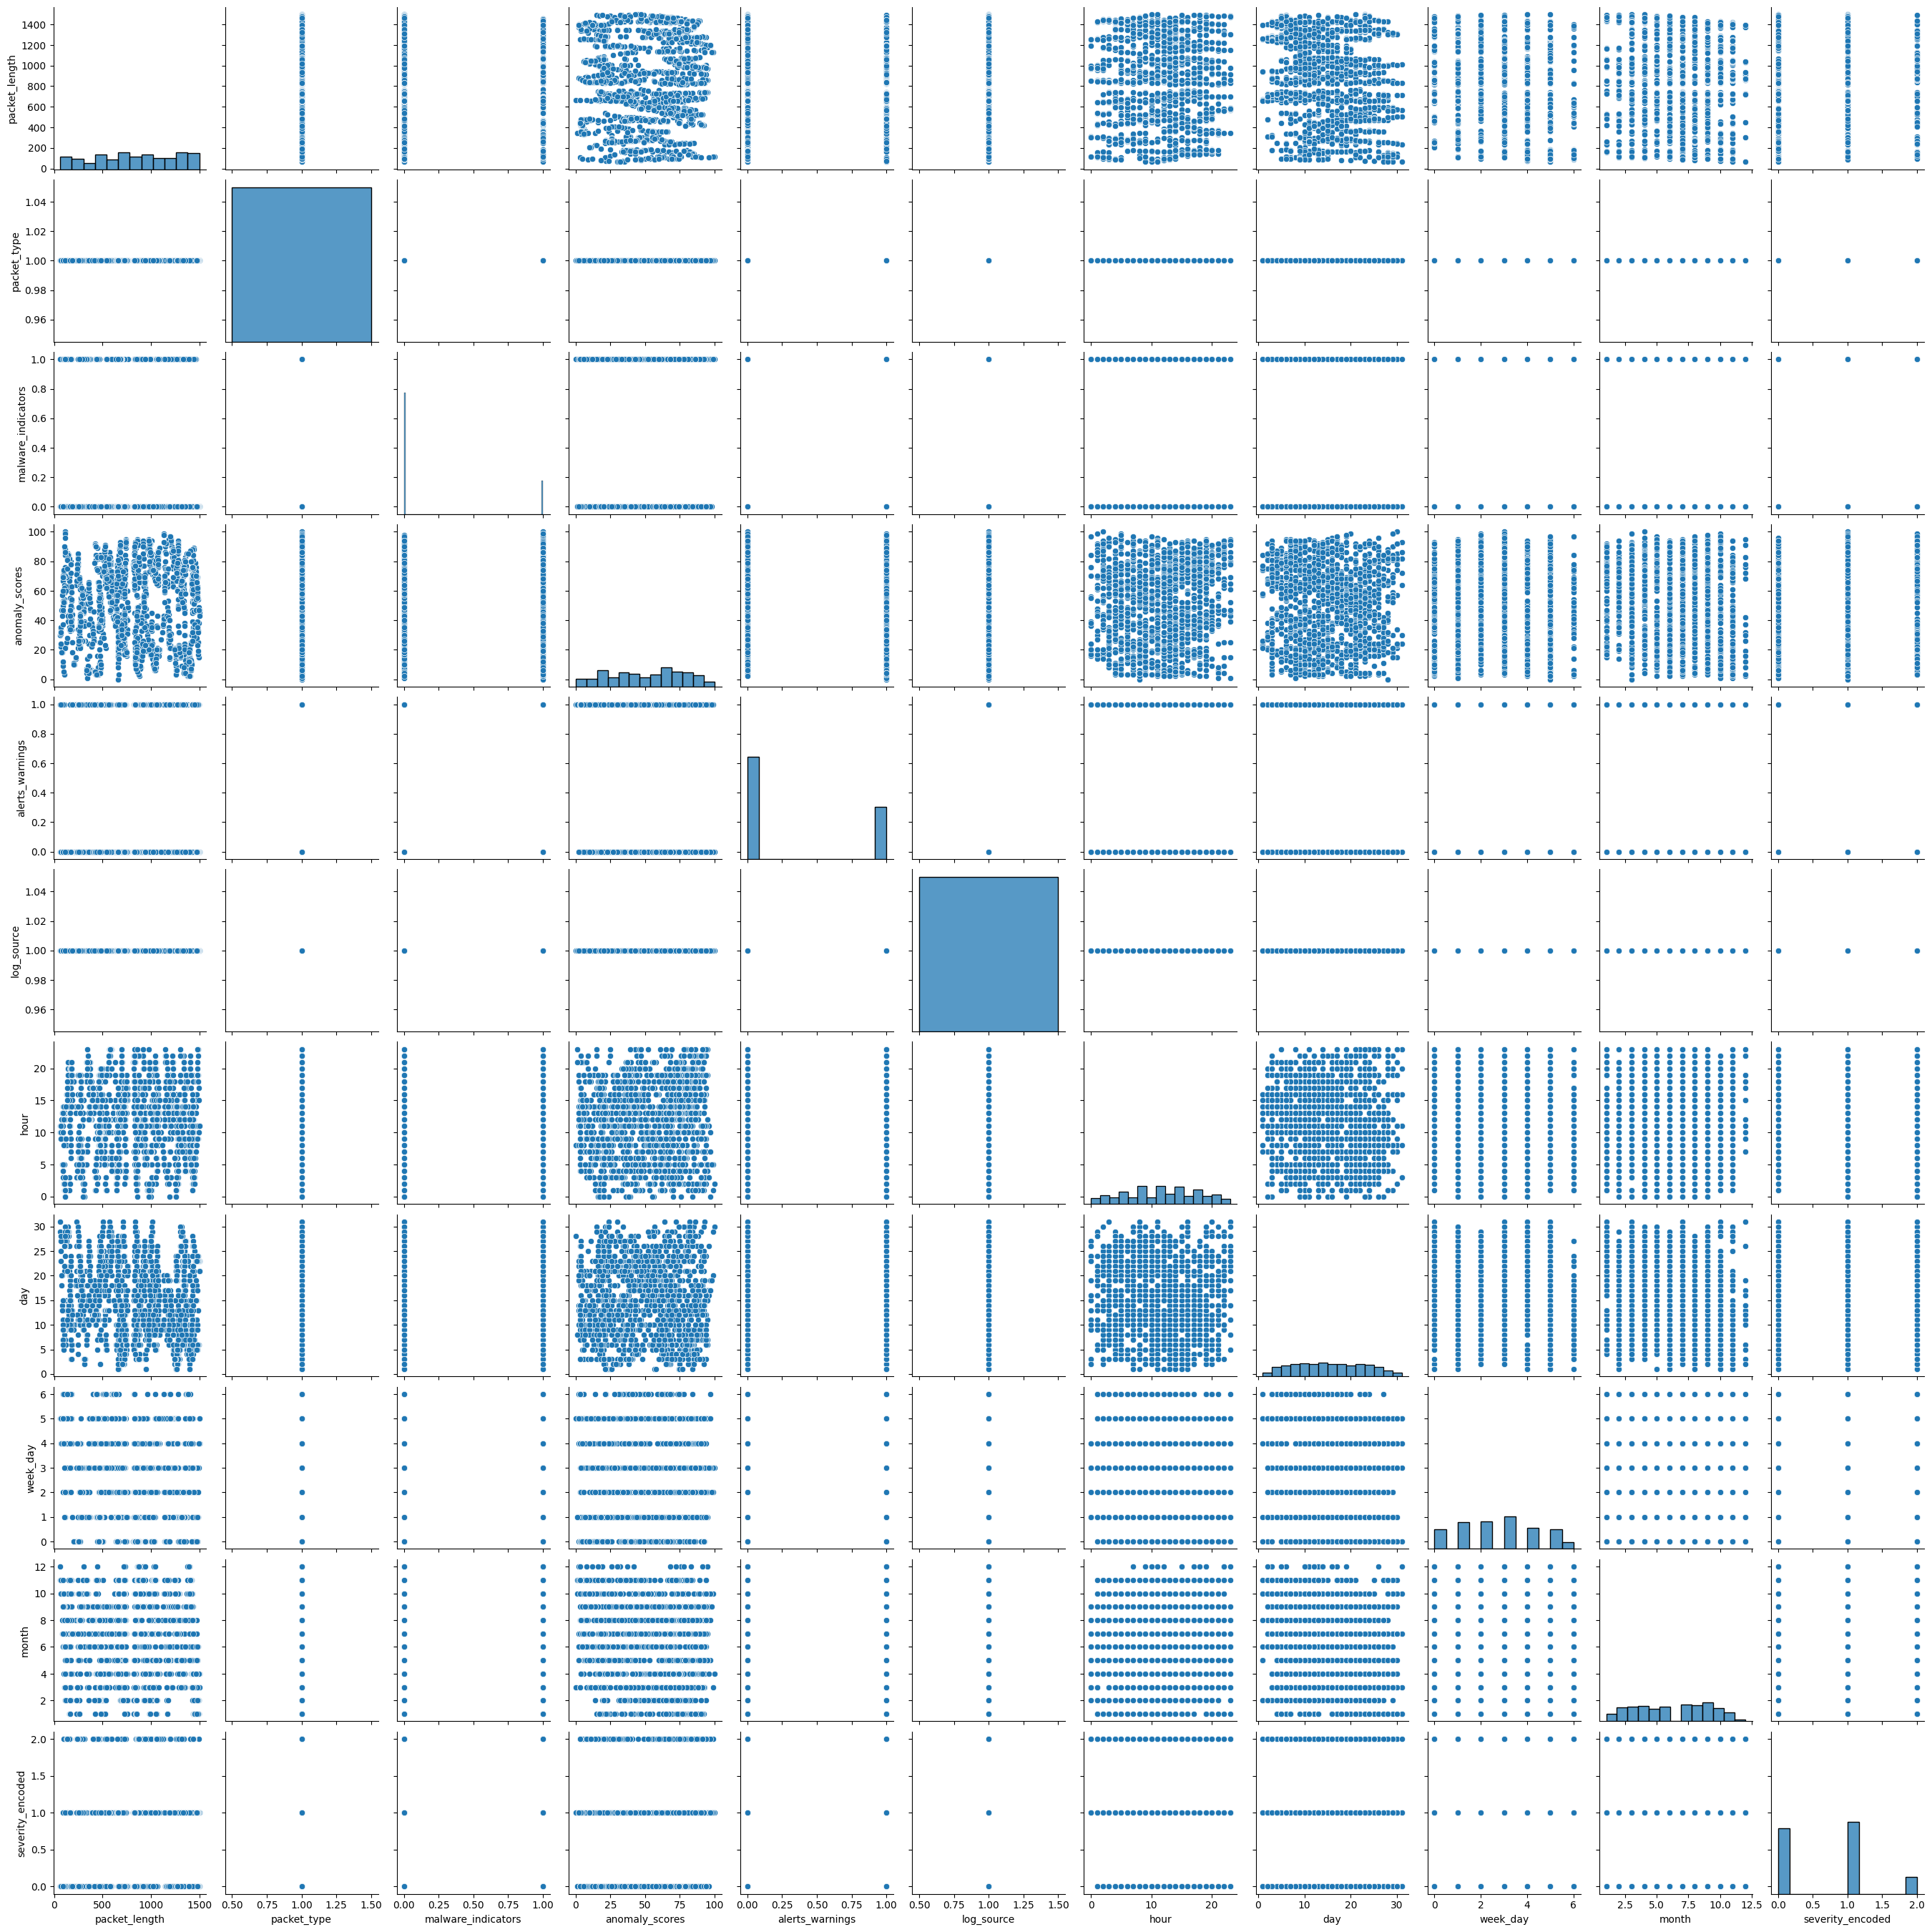

In [193]:
sns.pairplot(smote_ddos)

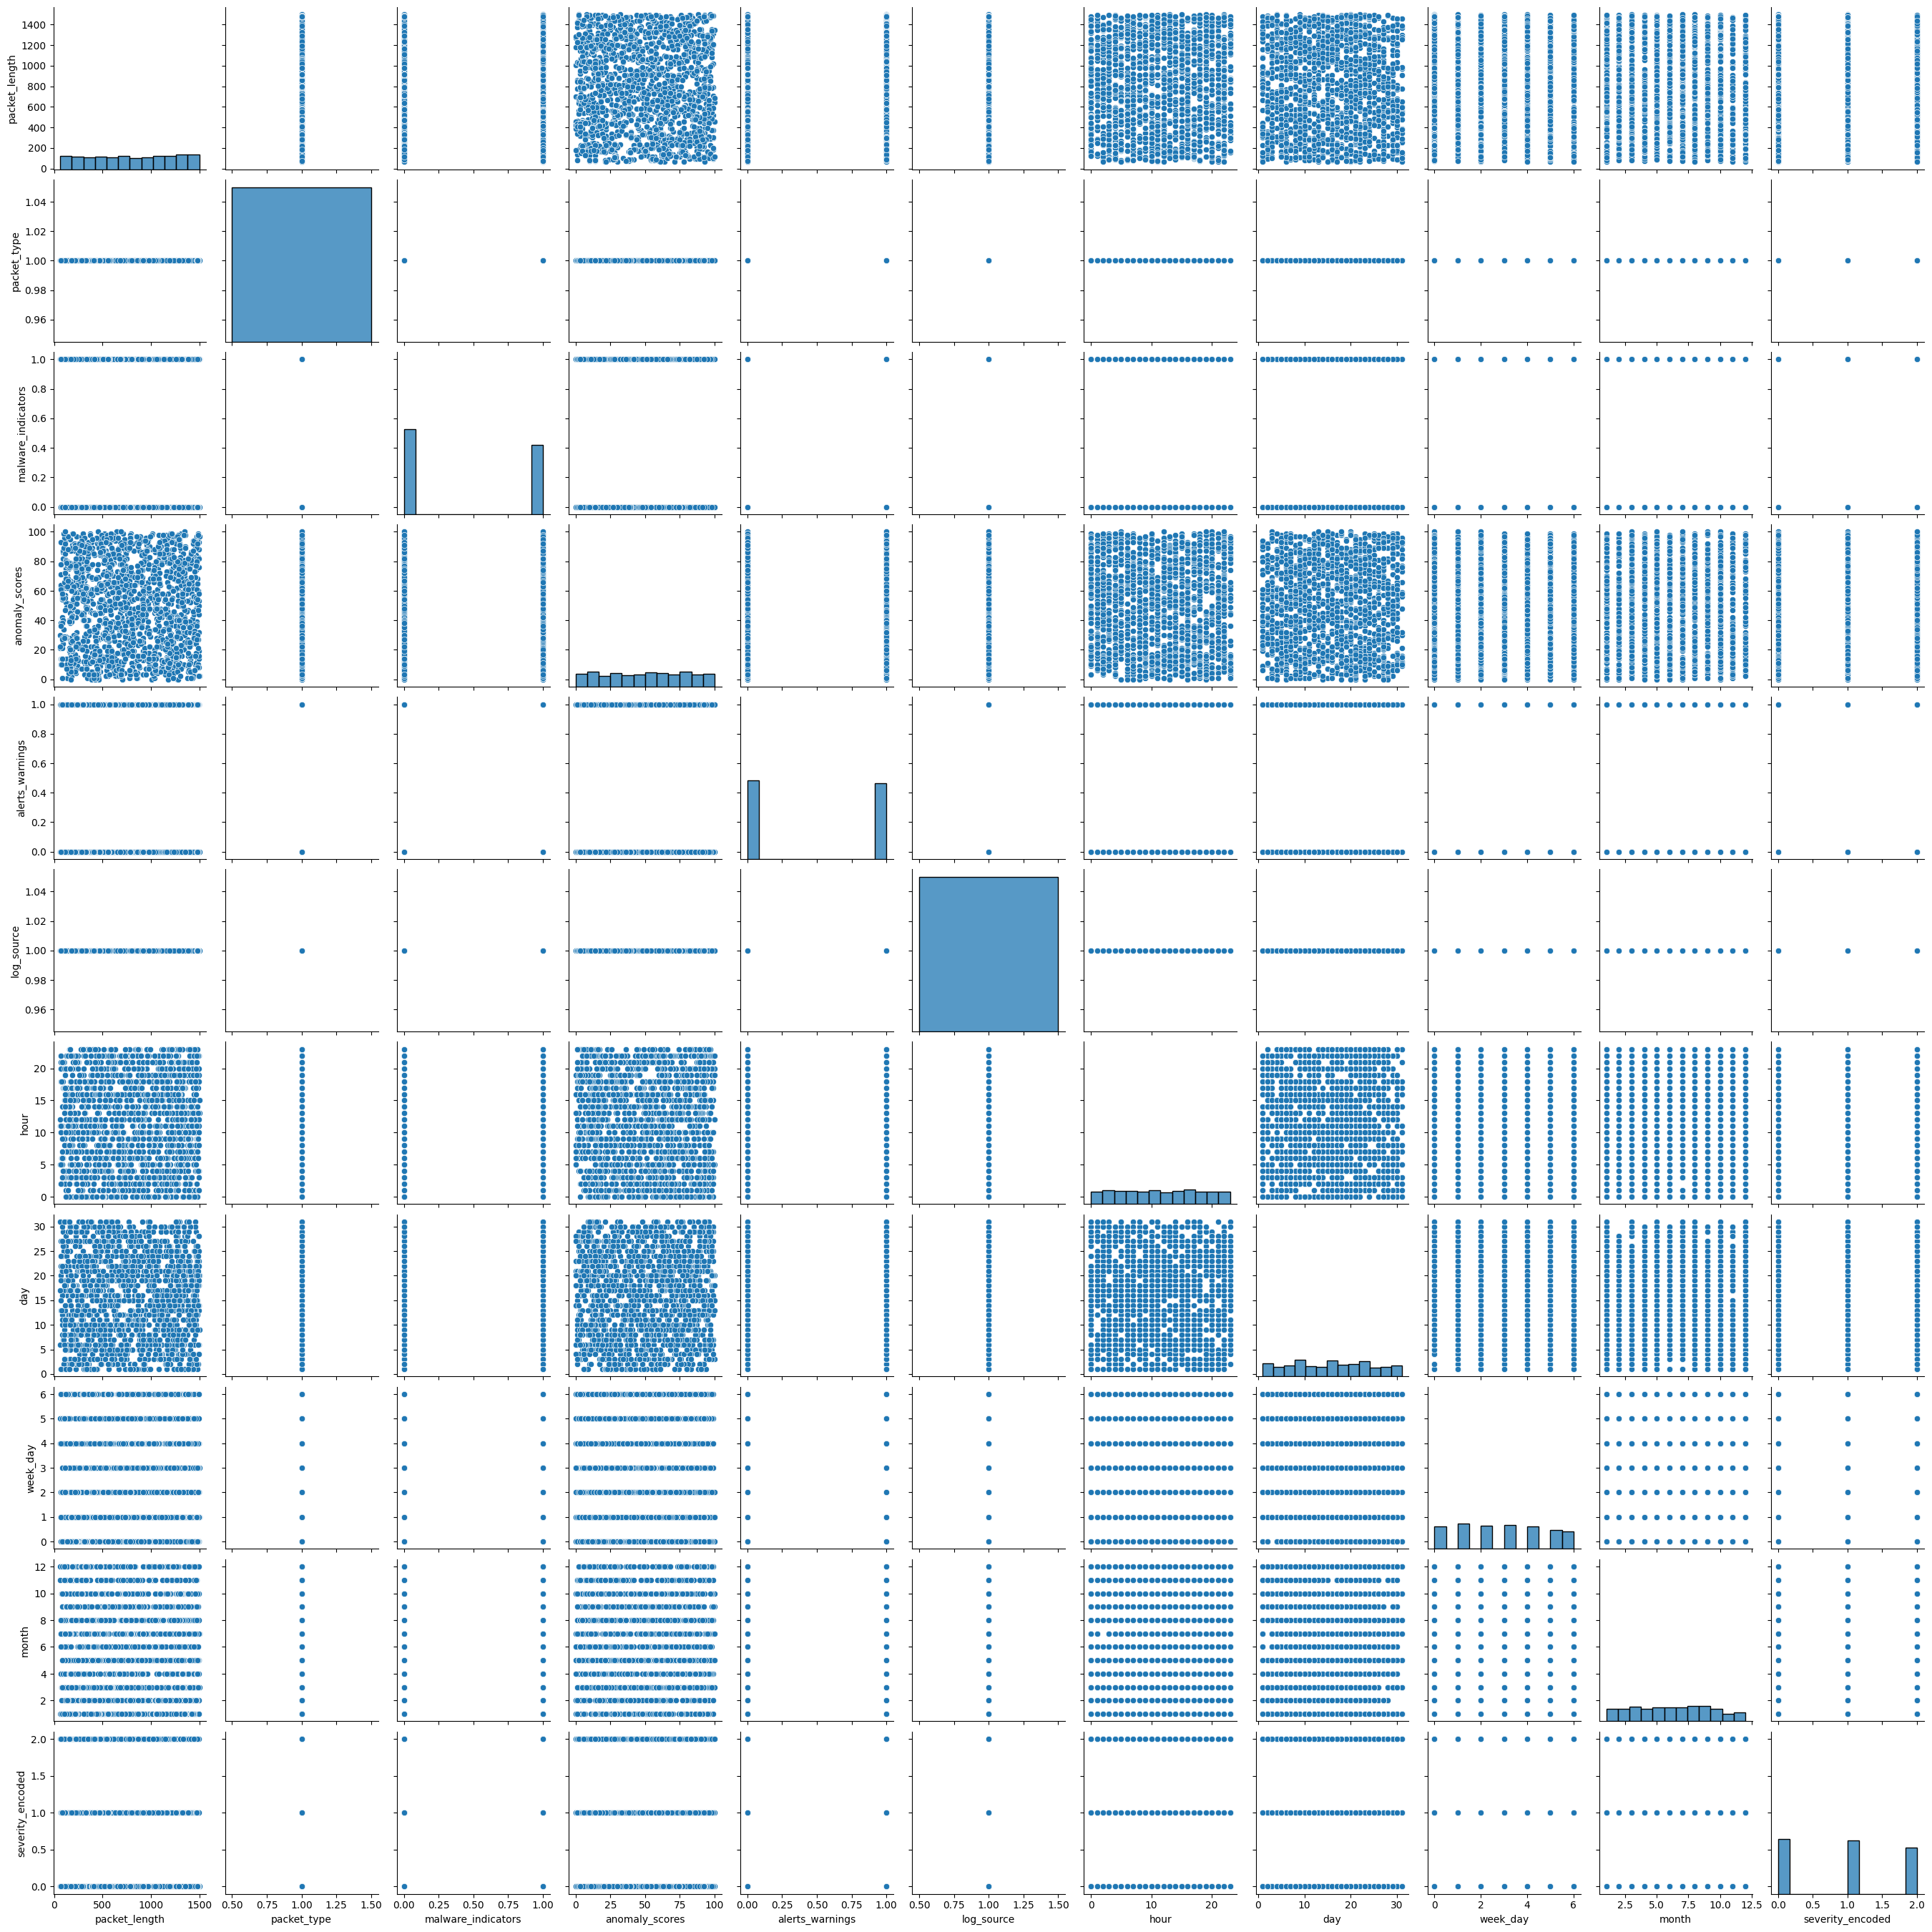

In [194]:
sns.pairplot(smote_intrusion)

In [195]:
combined_smote_df = pd.concat([smote_malware, smote_ddos, smote_intrusion], ignore_index=True) 

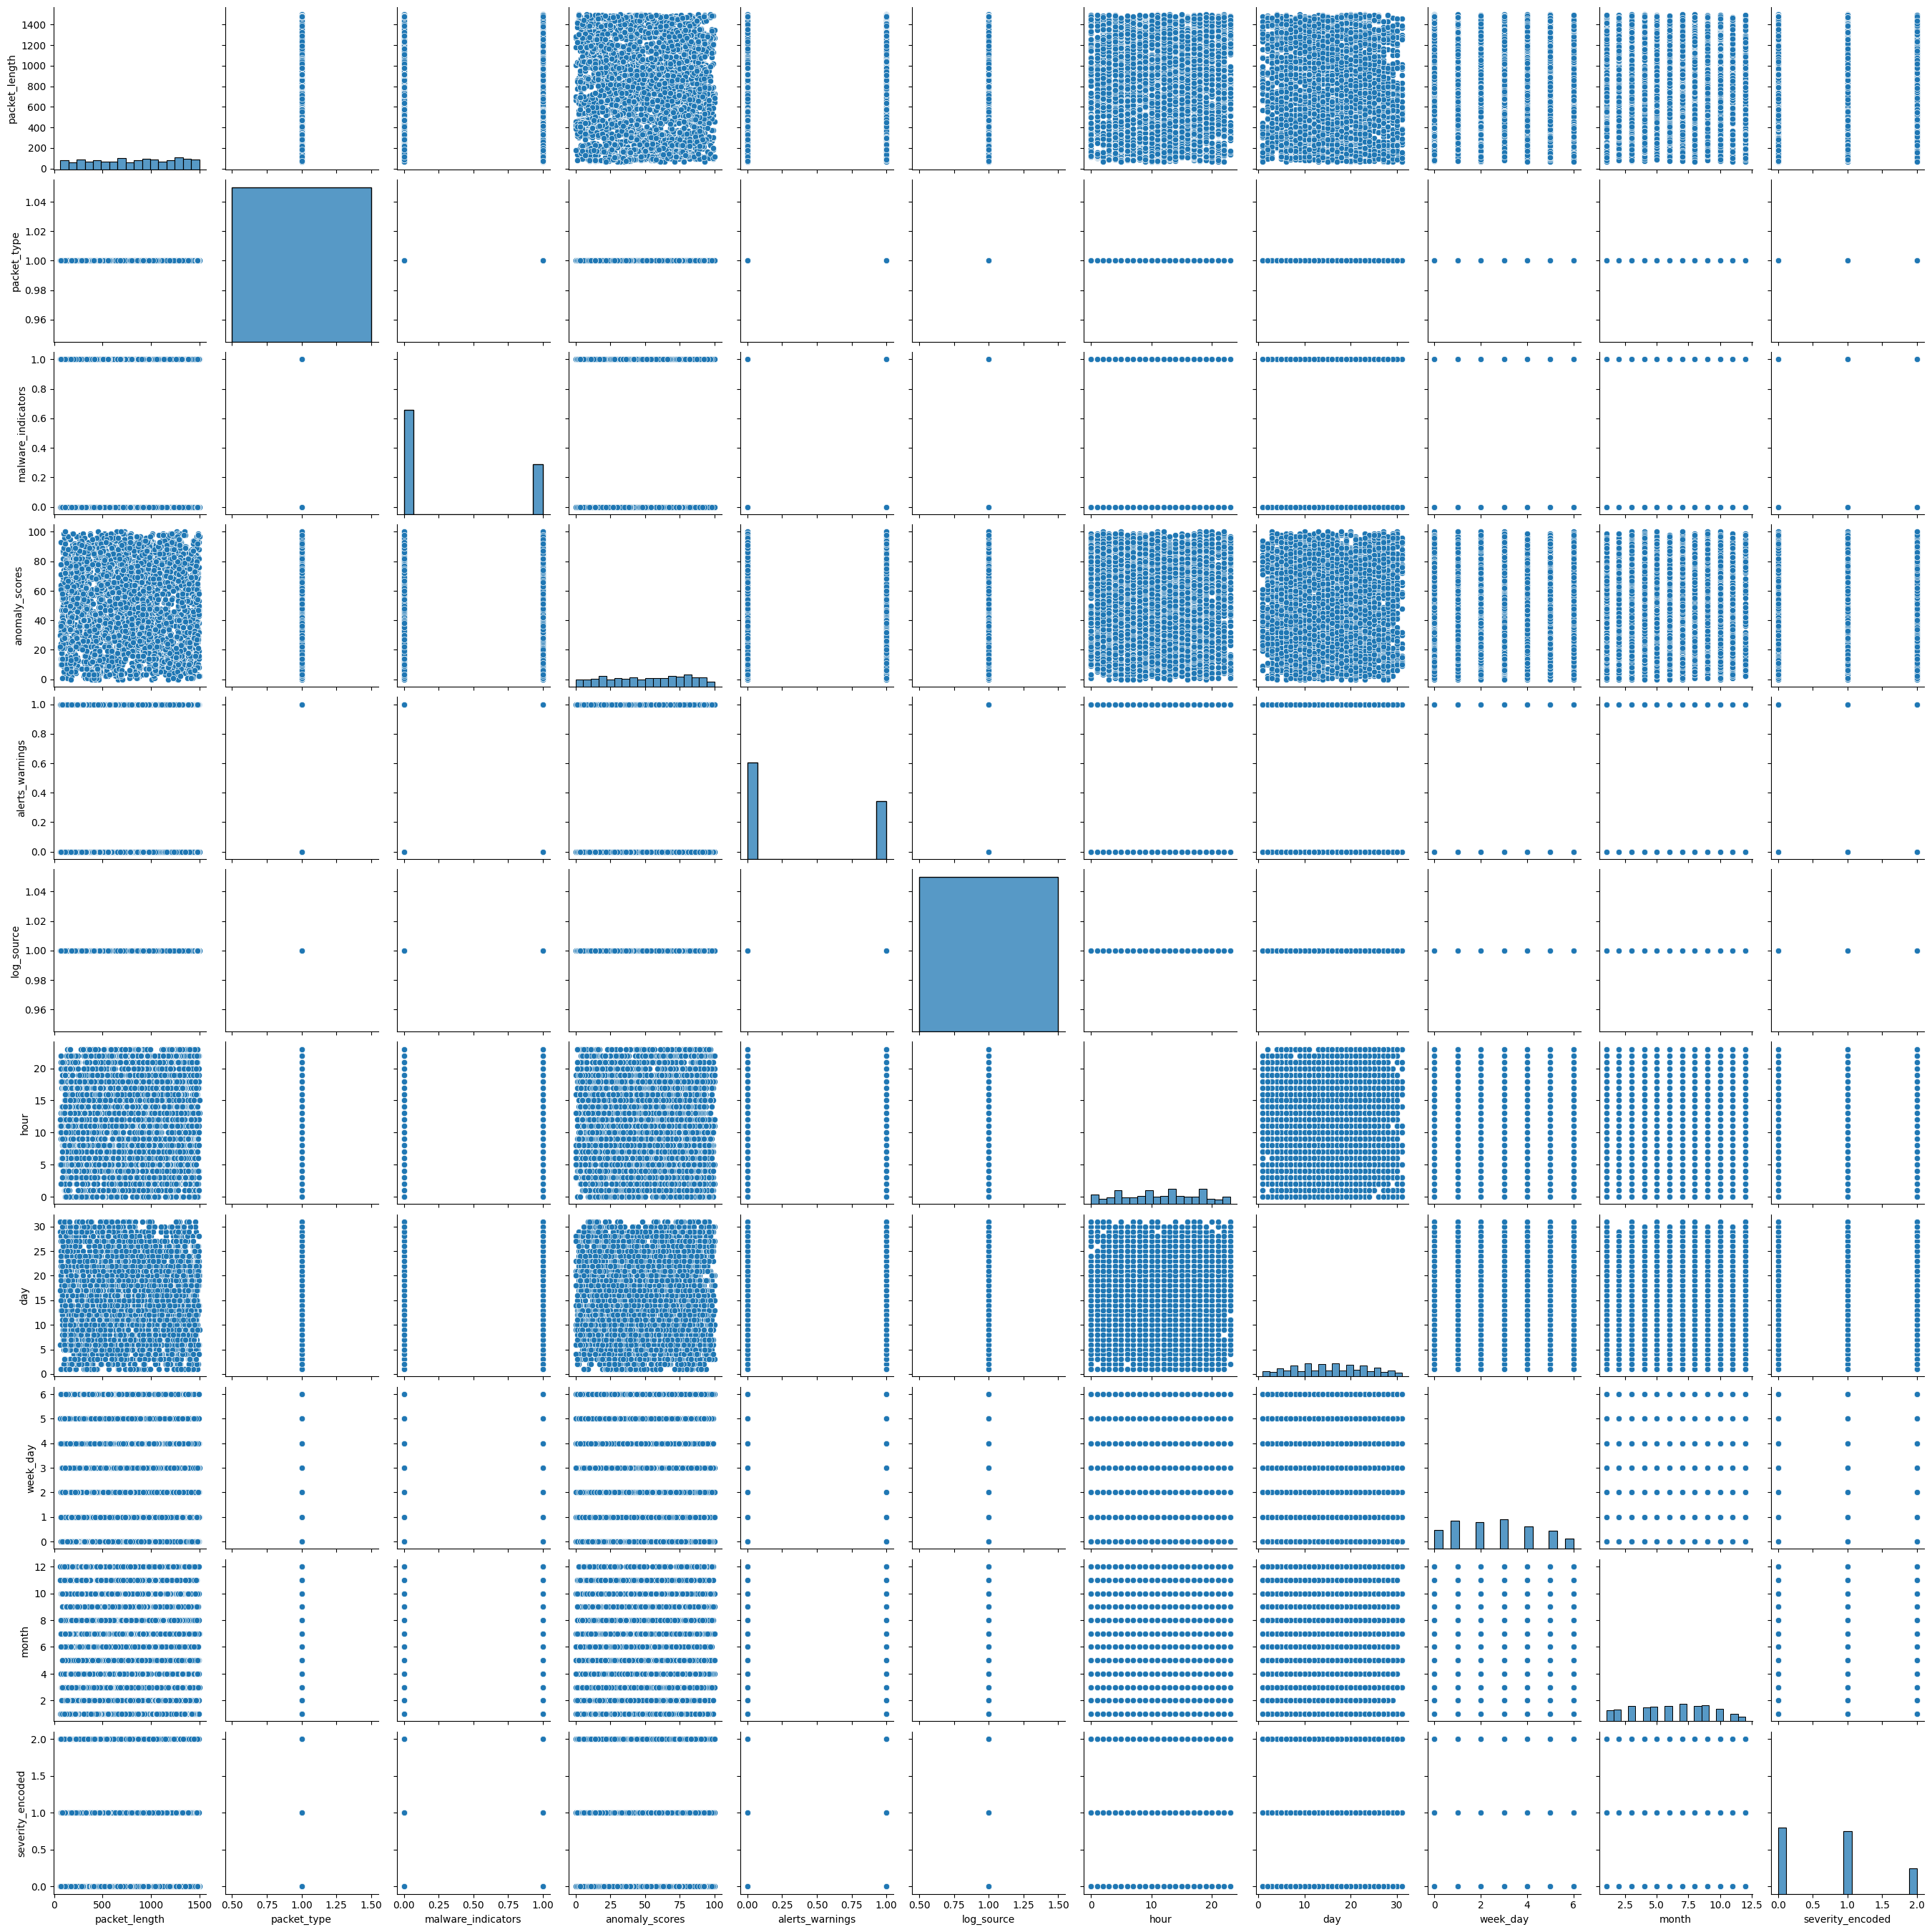

In [198]:
sns.pairplot(combined_smote_df)

<Axes: >

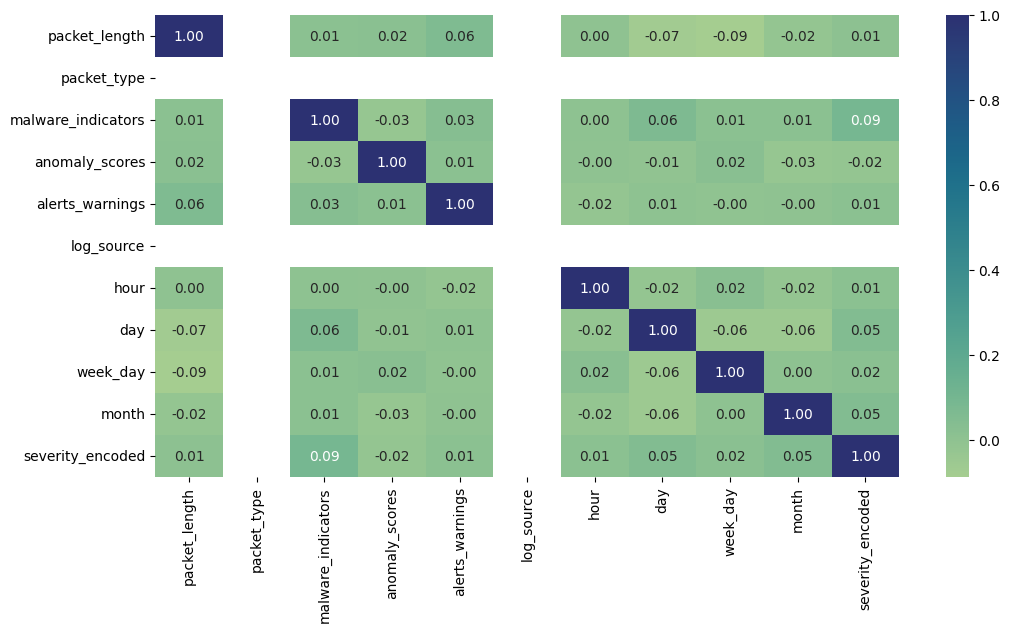

In [202]:
plt.figure(figsize=(12,6))
sns.heatmap(combined_smote_df.select_dtypes(['int64']).corr(), cmap="crest", annot=True, fmt='.2f')

In [203]:
combined_smote_df.head()

protocol  packet_length  packet_type traffic_type  malware_indicators  \
0      UDP            332            1          DNS                   1   
1      UDP           1366            1         HTTP                   1   
2      TCP            648            1         HTTP                   1   
3      TCP           1366            1          DNS                   0   
4     ICMP            516            1         HTTP                   0   

   anomaly_scores  alerts_warnings attack_signature action_taken  \
0              29                0  Known Pattern B      Blocked   
1              88                0  Known Pattern B       Logged   
2              27                1  Known Pattern A      Blocked   
3              83                1  Known Pattern A      Blocked   
4              77                0  Known Pattern A      Ignored   

  network_segment  log_source  hour  day  week_day  month  browser  device_os  \
0       Segment A           1    21    8         1     11  Mozilla    Windows   
1       Segment A           1    19   17         5      7  Mozilla  Macintosh   
2       Segment C           1     3   20         1      7  Mozilla    Windows   
3       Segment C           1    16   21         1      7  Mozilla       iPad   
4       Segment A           1    23   25         6      4  Mozilla      Linux   

   severity_encoded   target  
0                 2  Malware  
1                 2  Malware  
2                 1  Malware  
3                 0  Malware  
4                 0  Malware

In [ ]:
# save dataset to csv
smote_ddos.to_csv('smote_ddos.csv', index=False)
smote_intrusion.to_csv('smote_intrusion.csv', index=False)
smote_malware.to_csv('smote_malware.csv', index=False)

# Thought here

- what if we train our model with respect to each class one after another one
- this is called **transfer learning**
- we might need to mix some data points of previous attack type to the new attack type, so that the model does not completely forget
about the previous attack and learn completely the new attack, this is called catastrophic forgetting

